# DTSA 5510 - Unsupervised Algorithms in Machine Learning Final Project
Chris Murphy 07/23/2024

## Introduction 

For my final project, I wanted to attempt to create a sentiment analysis model. As I was thinking about ideas for my project, I thought back to the BBC News Classification mini project we were tasked with completing in week 4 and was thinking about different areas of unsupervised machine learning algorithms that could be applied to the same dataset. In this project, the articles were classified into five distinct categories but what if a model could be bilt to understand if the document that was being analyzed was a positive story or a negative story? This was an interesting project idea that I wanted to learn more about. After some additional research, I found there are many methodogies to answer this same question in the broader sentiment analysis category.      

With my mind made up on undertaking an in depth sentiment analysis project, I needed some data to work with. I had found a few interesting datasets that contained scraped Twitter data on various topics, however, nothing really resonated with me. After thinking about the data I could use some more, I realized I had all the data I needed to copmlete a sentiment analysis project. In my day job as a Data Analyst for an e-commerce company, everday I'm working with transactional Amazon data. Sure enough, there was Amazon review data that I could query. This data would become my foundation for my final project.

The dataset contains 10,000 distinct reviews for users who had purchased items in various categories in the United States. A sample of the data can be viewed below. Here are the columns and a basic overview of what they indicate:

- ID: The unique identifier of the review
- REVIEW_DATE: The date when the review was left
- IS_VERIFIED: Whether or not the review was verified. (I did not end up using this column)
- RATING: The rating the user gave for the product on a 1 to 5 scale
- REVIEW_TITLE: The title of the review 
- REVIEW_TEXT: The review the user left for the product 
- NAME: The country the user is in

## Imports

In [1]:
# standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# sklearn specific imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split

from nltk.tokenize import RegexpTokenizer

from langdetect import detect

from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Data import

In [2]:
# data import
reviews = pd.read_csv('data/reviews.csv')

## Basic data cleaning

In [3]:
# here is an initial view of a sample of rows in the dataset
reviews.sample(3)

,ID,REVIEW_DATE,IS_VERIFIED,RATING,REVIEW_TITLE,REVIEW_TEXT,NAME
8609,4200253,2022-12-03,True,5,Love mine,I have had mine for almost 2 months and use it...,United States
5833,5507867,2010-04-18,True,5,Alli works if you do,The first week I took Alli I counted my fat gr...,United States
8057,5846493,2017-12-16,True,1,They said tastless when you mix it into your f...,They said tastless when you mix it into your ...,United States


In [4]:
# From the sample dataframe above, the 'NAME' field is misleading, it will be changed from 'NAME' to 'COUNTRY'
reviews.rename(columns={'NAME': 'COUNTRY'}, inplace = True)

In [5]:
# there are 10,000 reviews in our initial dataset.
# The 'REVIEW_TITLE' column has one null entry which we will remove in a subsequent cell
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            10000 non-null  int64 
 1   REVIEW_DATE   10000 non-null  object
 2   IS_VERIFIED   10000 non-null  bool  
 3   RATING        10000 non-null  int64 
 4   REVIEW_TITLE  9999 non-null   object
 5   REVIEW_TEXT   10000 non-null  object
 6   COUNTRY       10000 non-null  object
dtypes: bool(1), int64(2), object(4)
memory usage: 478.6+ KB


In [6]:
# Identifying the only row with a null value. Since we really care about the 'REVIEW_TEXT'
# this row could probably be left in but I will remove it just to be safe
reviews[reviews['REVIEW_TITLE'].isnull()]
reviews.dropna(subset = ['REVIEW_TITLE'], axis = 0, inplace = True)

In [7]:
# double checking that there are no more null values in the updated dataset
reviews.isnull().sum()

ID              0
REVIEW_DATE     0
IS_VERIFIED     0
RATING          0
REVIEW_TITLE    0
REVIEW_TEXT     0
COUNTRY         0
dtype: int64

In [8]:
# There are two more adjustments that need to be made. The 'REVIEW_DATE' column should be a datetime
# also the 'ID' field should be an object
reviews['REVIEW_DATE'] = pd.to_datetime(reviews['REVIEW_DATE'])
reviews['ID'] = reviews['ID'].astype(object)

### Removing non-english reviews

There is another issue that will impact our results later on in the model testing phase. Even though these reviews are sourced from Amazon.com, there are reviews that are in different languages. A mask will be created to filter our all non English reviews.

In [9]:
# The langdetect package can be used to detect the language of a body of text.
# the package can then be used in a basic function to return the particular language of the review.
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = 'unknown'
    return lang

In [10]:
# Running the 'REVIEW_TEXT' column of our dataset through the detect_language function from above
reviews['LANGUAGE'] = reviews['REVIEW_TEXT'].apply(detect_language)

In [11]:
# Here are the results of the  we can see that there are many english reviews,
# but also other language as determined by the langdetect package
reviews['LANGUAGE'].value_counts()

LANGUAGE
en         9603
es          104
de           75
ja           63
fr           58
it           34
pt           11
ca            9
af            7
ro            6
no            6
nl            4
cy            3
so            3
sl            2
tl            2
et            2
da            2
id            2
unknown       1
sv            1
tr            1
Name: count, dtype: int64

In [12]:
# Example of a portuguese review in the dataset.
# This review is an example of a review that will be removed 
pd.set_option('display.max_colwidth', None)
reviews['REVIEW_TEXT'][reviews['LANGUAGE'] == 'pt'].head(1)

1925    Está muito diferente do normal. É o segundo Whey Protein Gold Standard de Baunilha que compro com este vendedor. O primeiro estava ok. Esse no entanto tem como data de vencimento Agosto de 2023, e o produto está com características estranhas, não possui a mesma viscosidade e o mesmo sabor. Se eu não conseguir substituir terei que jogar fora, pois me parece impróprio para ser consumido.
Name: REVIEW_TEXT, dtype: object

In [13]:
# although it should be said that this package is not perfect.
# for example, this review was classified as 'Norwegian' but in reality it is english.
# instead of going through each example, I decided to leave these edge cases alone
pd.set_option('display.max_colwidth', None)
reviews['REVIEW_TEXT'][reviews['LANGUAGE'] == 'no'].head(1)

88    False advertising.
Name: REVIEW_TEXT, dtype: object

In [14]:
# creating a mask to get only english reviews
english_mask = reviews['LANGUAGE'] == 'en'
english_reviews = reviews[english_mask]

In [15]:
# calculating the word count of the view. This will be interesting to visualize later on in the notebook
english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_94934/131805989.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['word_count'] = english_reviews['REVIEW_TEXT'].apply(lambda x: len(x.split()))


In [16]:
# from the 'REVIEW_DATE' column, getting the month and year that the review was submitted.
# this will be interesting to visualize
english_reviews['YEAR'] = english_reviews['REVIEW_DATE'].dt.year
english_reviews['MONTH'] = english_reviews['REVIEW_DATE'].dt.month

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_94934/1791540379.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['YEAR'] = english_reviews['REVIEW_DATE'].dt.year
/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_94934/1791540379.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_reviews['MONTH'] = english_reviews['REVIEW_DATE'].dt.month


In [17]:
print(f'The number of rows in the final dataset is: {len(english_reviews)}')

The number of rows in the final dataset is: 9603


## Visualizations

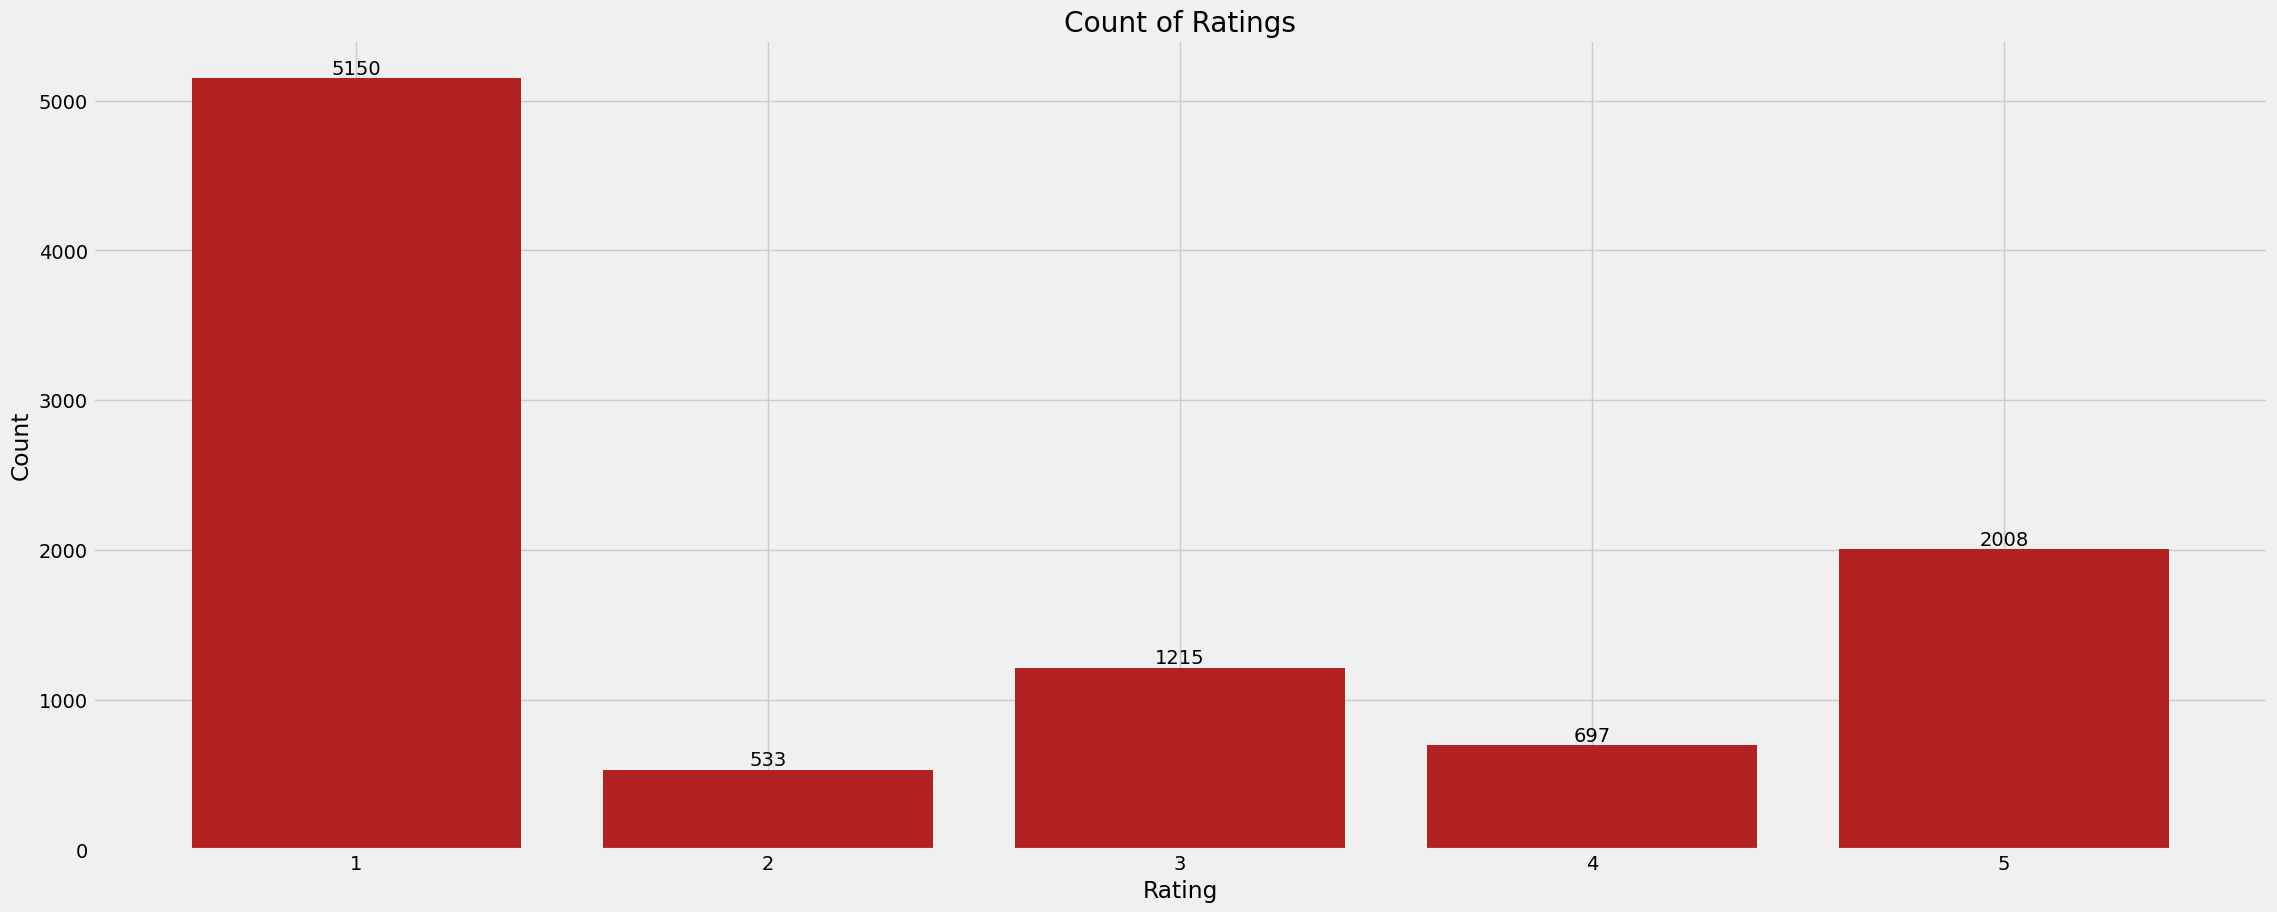

In [19]:
# This first visualization looks at the count of reviews.
# it can be seen that there are many 1 star reviews and many 5 star reviews.
# this is not a problem as I will not be exploring the relationship between variables, just the underlying text
plt.style.use('fivethirtyeight')
fix, ax = plt.subplots(figsize = (25, 10))

ratings = english_reviews['RATING'].value_counts()
ind = english_reviews['RATING'].unique()

plt.bar(ind, ratings, color = 'firebrick', align = 'center')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2,
            p.get_height(),
            '{:.0f}'.format(p.get_height()),
            ha='center',
            va='bottom'
           )

plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Text(0.5, 1.0, 'Number of words by review histogram')

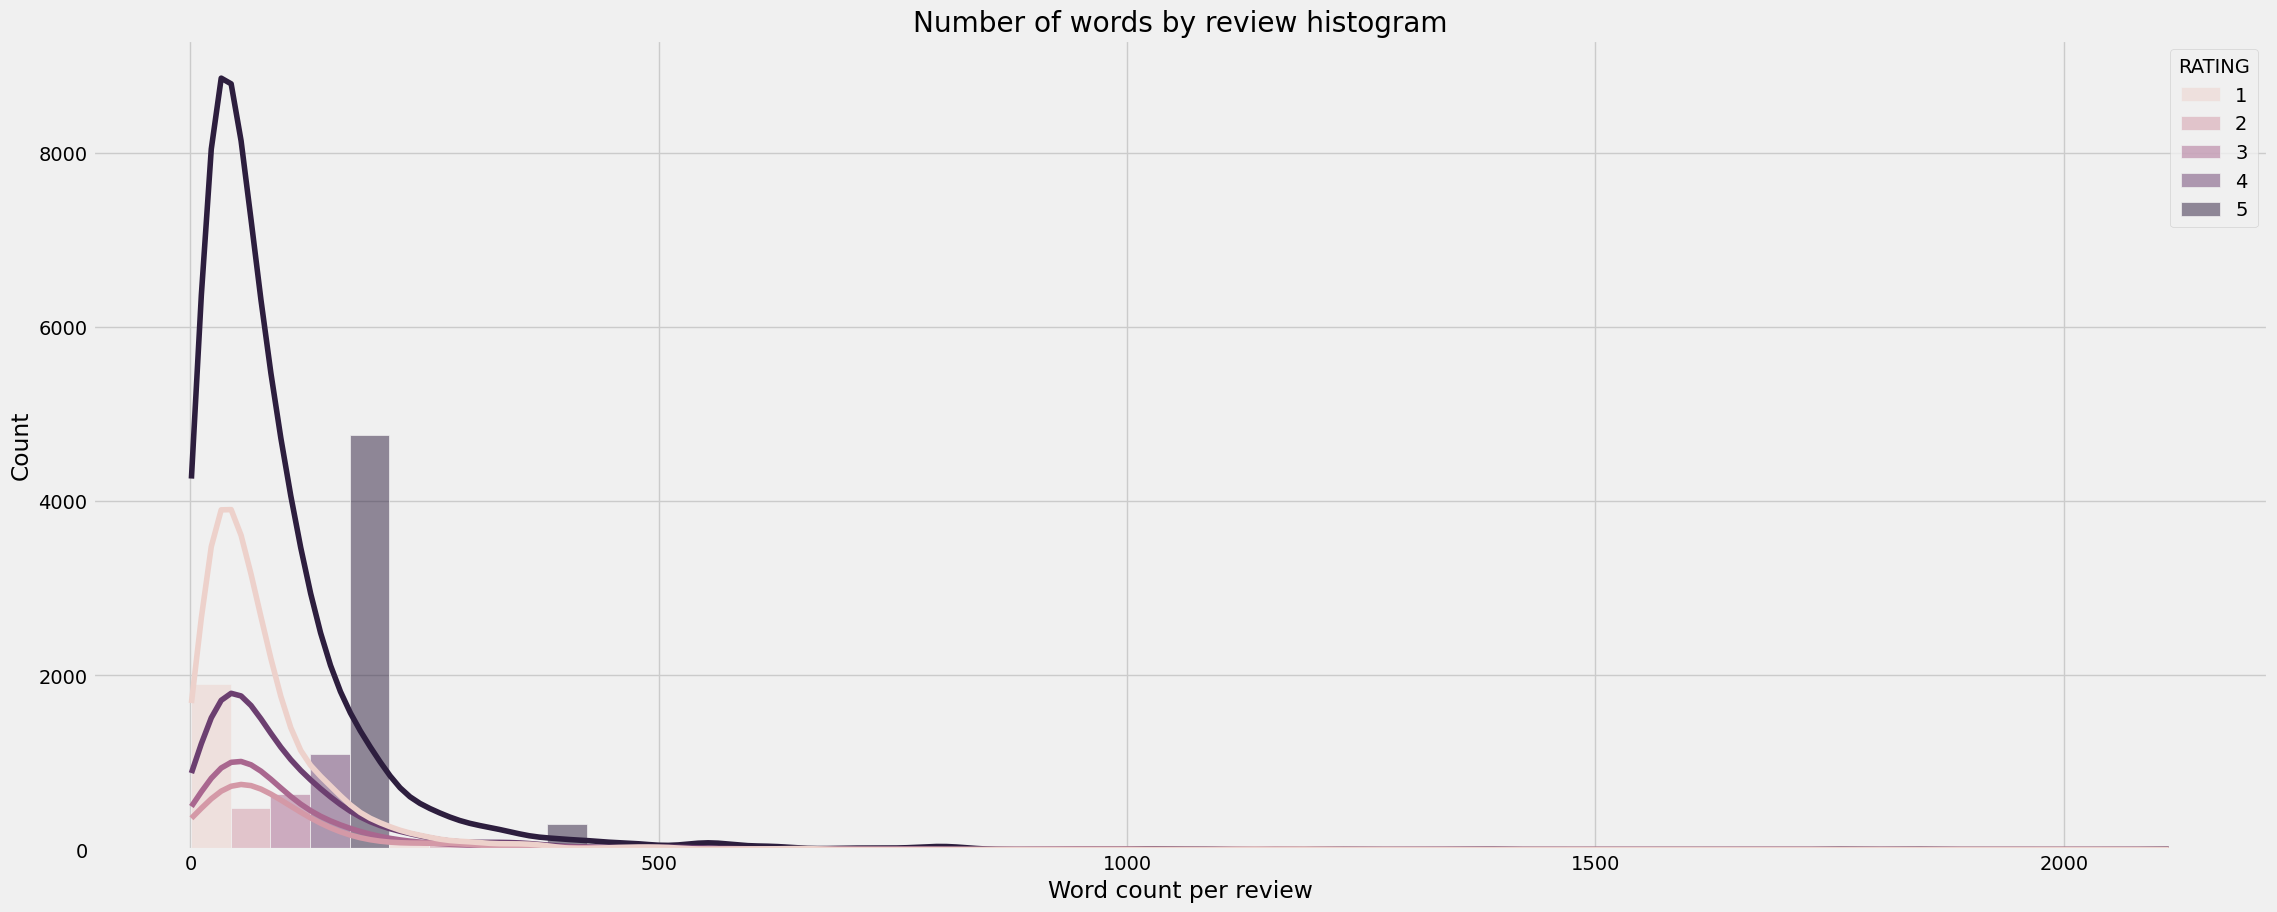

In [27]:
# The next visualization plots the distribution of the number of words in the review,
# separated by the rating of the review. It's interesting to see that the users who left a 5 star review
# left the longest reviews. 
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

sns.histplot(data=english_reviews, x='word_count', hue='RATING', multiple='dodge', legend='RATING', kde = True, bins = 10)

plt.xlabel('Word count per review')
plt.ylabel('Count')
plt.title('Number of words by review histogram')

/var/folders/lr/994tkpld58q9sbf0jsds90h80000gn/T/ipykernel_94934/3030392025.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)


Text(0, 0.5, 'Word count')

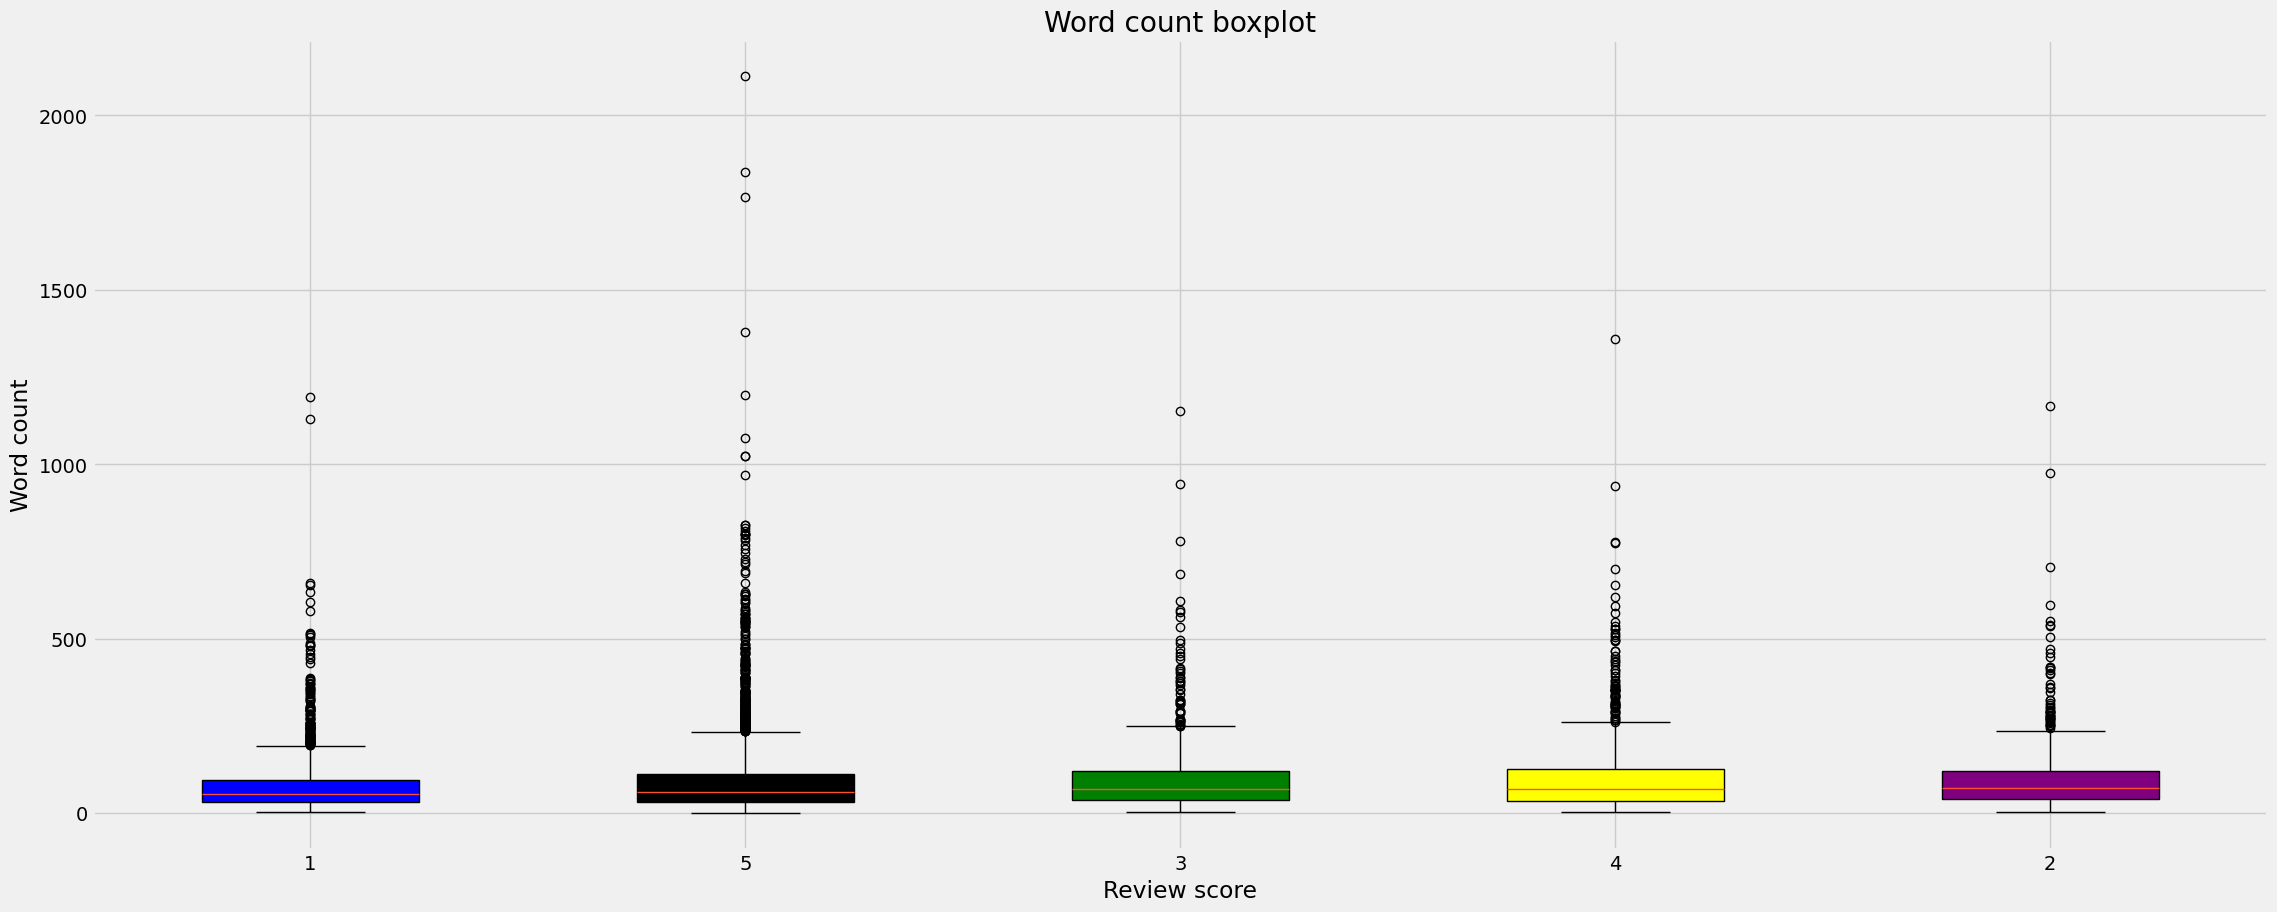

In [28]:
# here I am looking at the word count again, but in boxplot form. you can see the average review word count is
# a little less than 100, however there are major outliers, especially for the five star reviews.
# who has time to leave a 2112 word review?
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

wc_group = english_reviews.groupby('RATING')['word_count'].apply(list)
data = [wc_group[cat] for cat in english_reviews['RATING'].unique()]

bp = plt.boxplot(data, labels = english_reviews['RATING'].unique(), patch_artist=True)

colors = ['blue', 'black', 'green', 'yellow', 'purple']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Word count boxplot')
plt.xlabel('Review score')
plt.ylabel('Word count')

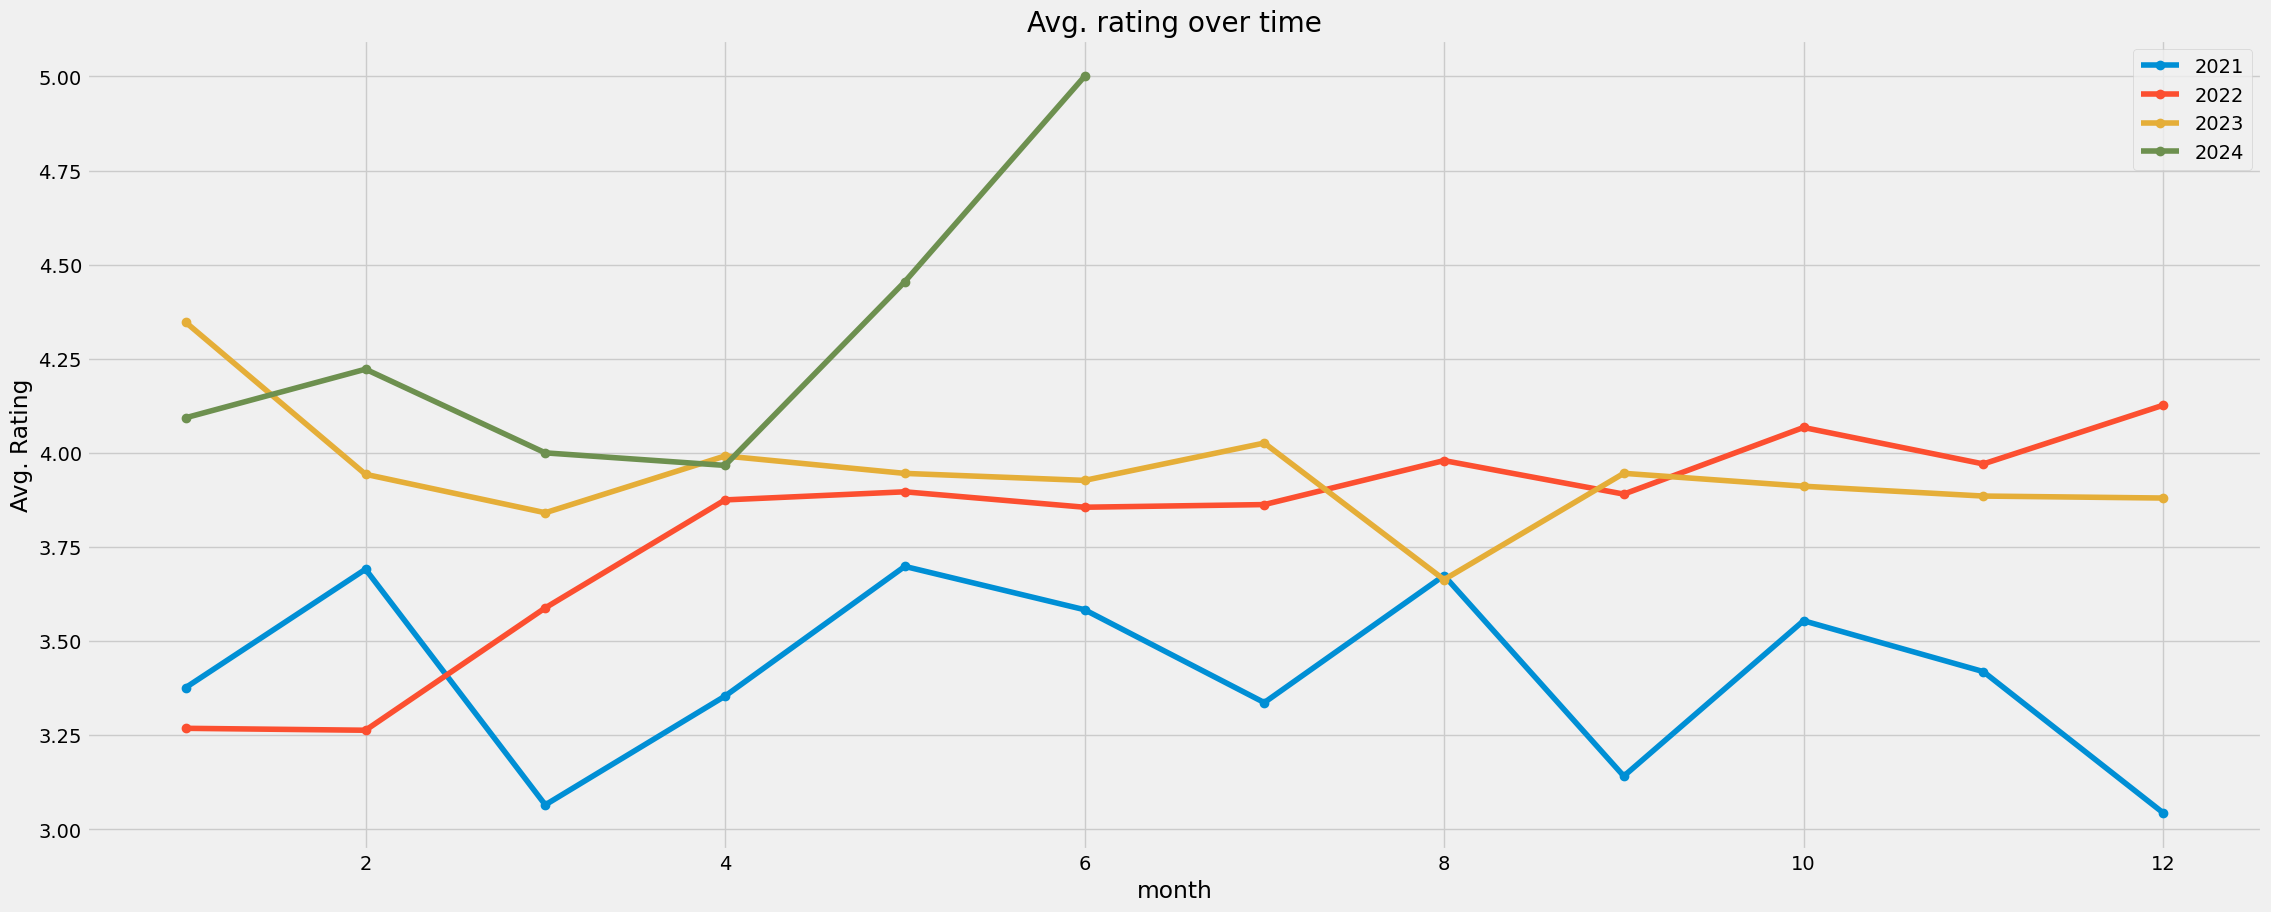

In [34]:
# does the year impact the average review? the graph below seems to indicate there is some evidence to suggest
# the year does impact the average review. why were people so angry online in 2021? the good news is that
# people leaving reviews seem to be pretty happy here in 2024
monthly_avg_rating = english_reviews.groupby(['YEAR', 'MONTH'])['RATING'].mean().reset_index()
filtered_rating = monthly_avg_rating[monthly_avg_rating['YEAR'].isin([2021, 2022, 2023, 2024])]
pivot_df = filtered_rating.pivot(index = 'MONTH', columns = 'YEAR', values='RATING')

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize = (25, 10))

for col in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[col], marker = 'o', label = col)

plt.xlabel('month')
plt.ylabel('Avg. Rating')
plt.title('Avg. rating over time')
plt.legend()

In [35]:
# Here is a funny review I thought I would leave here...
pd.set_option('display.max_colwidth', None)
english_reviews['REVIEW_TEXT'].sample(1, random_state = 14)

4642    If you have horrible allergies, then this is your legal crack! And without all of the panhandling and general unsavory behavior that comes with it! About the only downside is that it's not in a gallon jug.
Name: REVIEW_TEXT, dtype: object

## Count Vectorize

In [ ]:

def remove_punctuation(text):
    final_text = []
    for row in text:
        clean_row = "".join(u for u in row if u not in ('?', '.', ';', ':', '!', '"', "'", '(', ')', '[', ']', '/', ',', '-', '*'))
        final_text.append(clean_row.lower())
    
    return final_text

In [ ]:
token = RegexpTokenizer(f'[a-zA-Z0-9]+')

In [ ]:
english_reviews['REVIEW_TEXT'] = remove_punctuation(english_reviews['REVIEW_TEXT'])

In [ ]:
cv = CountVectorizer(stop_words = 'english', ngram_range = (1,2), tokenizer = token.tokenize)

In [ ]:
text_counts = cv.fit_transform(english_reviews['REVIEW_TEXT'])

## Train Test Split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(text_counts, english_reviews['RATING'], test_size = 0.2, random_state = 42, stratify=english_reviews['RATING'])

## Training the MNB model 

In [ ]:
MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

In [ ]:
predicted = MNB.predict(X_test)

In [ ]:
acc_score = accuracy_score(predicted, Y_test)

In [ ]:
print(f'The accuracy score of the Multimodial Naive Bayes model is: {round(acc_score, 2)}')

In [ ]:
predicted[:5]

In [ ]:
Y_test[:5]

In [ ]:
cm = confusion_matrix(Y_test, predicted)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(Y_test))
disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Text blob

Polartiy determines the sentiment of the text. -1 = highly negative review and 1 denotes a highly positive sentiment.

Subjectivity determines whether a text input is fact vs personal information. 0 denotes a fact and 1 denotes a personal opinion.

In [ ]:
english_reviews['REVIEW_TEXT'].iloc[284]

In [ ]:
p1 = TextBlob(english_reviews['REVIEW_TEXT'].iloc[284]).sentiment.polarity
s1 = TextBlob(english_reviews['REVIEW_TEXT'].iloc[284]).sentiment.subjectivity

In [ ]:
print(f'The polarity of the test token is : {round(p1, 4)} and the subjectivity of the test token is: {round(s1, 4)}')

In [ ]:
print(f'The actual rating was: {english_reviews['RATING'].iloc[284]}')

In [ ]:
def calculate_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

def calculate_subjectivity(text):
    blob = TextBlob(text)
    return blob.sentiment.subjectivity

In [ ]:
english_reviews['TEXT_BLOB_POLARITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_polarity)
english_reviews['TEXT_BLOB_SUBJECTIVITY_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_subjectivity)

In [ ]:
def map_rating(value):
    mapped_value = (value + 1) * 2.5 + 0.5
    mapped_rating = round(mapped_value)
    mapped_rating = max(1, min(5, mapped_rating))
    return mapped_rating

In [ ]:
english_reviews['TEXT_BLOB_POLARITY_MAPPED'] = english_reviews['TEXT_BLOB_POLARITY_RAW'].apply(map_rating)

In [ ]:
english_reviews.sample(1)

In [ ]:
english_reviews['TEXT_BLOB_POLARITY_MAPPED'].values

In [ ]:
english_reviews['RATING'].values

In [ ]:
acc_score_2 = accuracy_score(english_reviews['TEXT_BLOB_POLARITY_MAPPED'].values, english_reviews['RATING'].values)

In [ ]:
print(f'The accuracy score of the \'Text Blob\' model accuracy score is: {round(acc_score_2, 4)}')

In [ ]:
cm = confusion_matrix(english_reviews['RATING'].values, english_reviews['TEXT_BLOB_POLARITY_MAPPED'].values)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(Y_test))
disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### VADER

In [ ]:
sentiment = SentimentIntensityAnalyzer()

In [ ]:
t_1 = english_reviews['REVIEW_TEXT'].iloc[1336]
t_1

In [ ]:
sent_1 = sentiment.polarity_scores(t_1)
print(f'The VADER sentiment of review 1337 is: {sent_1}')

In [ ]:
print(f'The actual rating for review 1337 is: {english_reviews['RATING'].iloc[1336]}')

In [ ]:
def calculate_sentiment(text):
    vader = sentiment.polarity_scores(text)
    return vader

In [ ]:
english_reviews['VADER_SENTIMENT_RAW'] = english_reviews['REVIEW_TEXT'].apply(calculate_sentiment)

In [ ]:
english_reviews.iloc[72]

In [ ]:
def map_sentiment(sentiment):
    pos_score = sentiment['pos']
    neg_score = sentiment['neg']

    weighted_score = (pos_score - neg_score) * 2 + 3
    mapped_score = round(max(1, min(5, weighted_score)))
    return mapped_score

In [ ]:
print(f'The mapped sentiment for review 1337 is: {map_sentiment(sent_1)}')

In [ ]:
english_reviews['VADER_SENTIMENT_MAPPED'] = english_reviews['VADER_SENTIMENT_RAW'].apply(map_sentiment)

In [ ]:
english_reviews.iloc[72]

In [ ]:
acc_score_3 = accuracy_score(english_reviews['VADER_SENTIMENT_MAPPED'].values, english_reviews['RATING'].values)

In [ ]:
print(f'The accuracy score of the \'VADER\' model accuracy score is: {round(acc_score_3, 4)}')

In [ ]:
cm = confusion_matrix(english_reviews['RATING'].values, english_reviews['VADER_SENTIMENT_MAPPED'].values)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = np.unique(Y_test))
disp.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Conclsion